In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z = np.arange(0, 1500)

Arctic boundary layer:
| Name | Value |
|------|-------|
| Stability | 2-6 K |
| Inversion Height | 200-600 m |

# Theta

In [3]:
z_inv = 700
inv_thickness = 100
inv_strength = 6
theta_0 = 263
ft_slope = 0.005

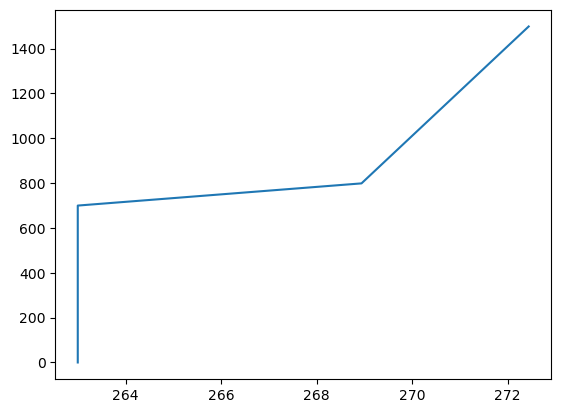

In [4]:
theta = np.zeros(len(z))
for i, zi in enumerate(z):
    if zi < z_inv:
        theta[i] = theta_0
    elif zi >= z_inv and zi < (z_inv + inv_thickness):
        theta[i] = theta_0 + (zi-z_inv) * (inv_strength/inv_thickness)
    else:
        theta[i] = theta[i-1] + ft_slope

plt.plot(theta,z)

# Pressure

In [6]:
pres = np.zeros(len(z))

for i,zi in enumerate(z):
    pres[i] = (100000 + (-1.2985 * 9.8) * (zi))/100

# Moisture

In [7]:
from metpy.calc import mixing_ratio_from_relative_humidity, relative_humidity_from_mixing_ratio
from metpy.units import units

In [8]:
from metpy.constants import g, Rd, Lv, Cp_d, Rv, rho_d
from metpy.calc import temperature_from_potential_temperature, mixing_ratio_from_relative_humidity

In [9]:
cbh = 400
cthick = 300
rh_0 = .85
drh = -0.0024
minv = 0

Set cloud base height and base levels

In [10]:
z0 = cbh
z1 = cbh + cthick
z_star = np.arange(z0, z1+1) * units('meter')

In [11]:
T = temperature_from_potential_temperature(pres[z0:z1+1] * units('hPa'), theta[z0:z1+1]*units('K'))
qv = mixing_ratio_from_relative_humidity(pres[z0:z1+1] * units('hPa'), T, 1.0)

## Set BL qv from cloud base


In [12]:
qv_bl = qv[0]
qv_bl

0.001360824270266689 <Unit('dimensionless')>

## Adiabatic profile

In [13]:
a1 = (g/(Rd*T))*(((Lv* Rd)/(Cp_d*Rd*T)) - 1)
a2 = (1/qv) + (Lv**2 / (Cp_d * Rv * T**2))
lwc = (a1/a2)  * np.arange(len(z_star)) * units('m')


LWP

In [14]:
np.trapz(lwc.to('g/kg') * rho_d)

63.19687027395735 <Unit('gram / meter ** 3')>

## Put it all together

In [15]:
temp = temperature_from_potential_temperature(pres*units('hPa'), theta * units('K'))

Expand mixing ratio outside of cloud:
* Moisture is constant from cloud base to surface
* RH of 70% above cloud

In [17]:
qvfull = np.zeros(len(z))

for i in range(len(qvfull)):
    if i < z0: qvfull[i] = qv_bl
    elif i >= z0 and i <= z1: qvfull[i] = mixing_ratio_from_relative_humidity(pres[i] * units('hPa'), temp[i], 1.0) + qv[i-z0]
    elif i > z0 and z[i] <= z_inv+inv_thickness: qvfull[i] = qv[-1]
    else: qvfull[i] = mixing_ratio_from_relative_humidity(pres[i] * units('hPa'), temp[i], 0.7)

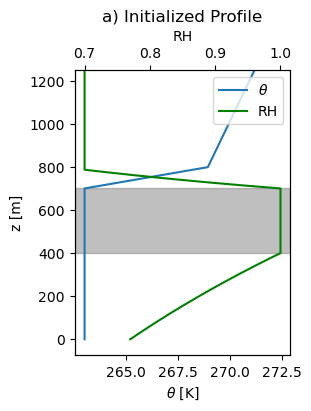

In [22]:
rhplot = relative_humidity_from_mixing_ratio(pres * units('hPa'), temp, qvfull)

rhplot = np.where(rhplot > 1.0, 1.0, rhplot)
rhplot = np.where(rhplot < .7, .7, rhplot)
# plt.plot(rhplot)

fig = plt.figure(figsize=(3,4), constrained_layout=True)

ax = plt.subplot()
p1 = ax.plot(theta, z, label='$\\theta$')
ax2 = ax.twiny()
p2 = ax2.plot(rhplot.magnitude, z, color='g', label='RH')
ax.axhspan(cbh, cbh+cthick, color='grey', alpha=.5)

handles = p1 + p2
ax.set_ylim(None, 1250)
plt.legend(handles=handles)

ax.set_xlabel('$\\theta$ [K]')
ax2.set_xlabel('RH')
ax.set_ylabel('z [m]')
plt.title('a) Initialized Profile')
plt.savefig('./paper_plots/01a.pdf')